# Homework 4: Modeling Text Data

### Team Member 1:
* UNI:  WL2522
* Name: Wilson Lui

### Team Member 2 [optional]:
* UNI:  
* Name:


You can find the data here: https://data.boston.gov/dataset/vision-zero-entry

# Task1 - Data Cleaning  [10 points]

Load the data, visualize the class distribution. Clean up the target labels. Some categories have been arbitrarily split and need to be consolidated. 

First, rows with no comments or duplicate rows that have the same combination of request type and comment are removed. Rows with  comments that are less than 12 characters long were also removed due to comments of that length not being too informative.


Then, embedded image tags are removed from the categories.

Having removed the embedded image tags from the categories, the following categories are consolidated due to them having the same meaning with different wordings:


1. "bike facilities don't exist or need improvement" / "there are no bike facilities or they need maintenance"

2. "sidewalks/ramps don't exist or need improvement" / "there are no sidewalks or they need maintenance"

3. "the wait for the "Walk" signal is too long" / "people have to wait too long for the "Walk" signal"

4. "the roadway surface needs improvement" / "the roadway surface needs maintenance"

5. "it’s hard to see / low visibility" / "it’s hard for people to see each other"

6. "it's too far / too many lanes to cross" / "people have to cross too many lanes / too far"

7. "people are not given enough time to cross the street" / "there's not enough time to cross the street"

The following categories are very similar to each other, but not quite the same, and thus were not combined during this preprocessing step:


"people don't yield while going straight" / "people don't yield while turning" /  "people run red lights / stop signs"


Whenever categories are consolidated, I merge the category with fewer data points into the one with more data points.


In [171]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from collections import Counter

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from sklearn.preprocessing import Normalizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier

data = pd.read_csv('Vision_Zero_Entry.csv')


["bike facilities don't exist or need improvement" 'of something that is not listed here'
 "people don't yield while going straight" 'it’s hard to see / low visibility'
 "people don't yield while turning" 'people double park their vehicles'
 'the wait for the "Walk" signal is too long' "sidewalks/ramps don't exist or need improvement"
 'people speed' 'people cross away from the crosswalks'
 "there's not enough time to cross the street" "it's too far / too many lanes to cross"
 'people run red lights / stop signs' 'the roadway surface needs improvement'
 'there are no bike facilities or they need maintenance' 'the roadway surface needs maintenance'
 'people have to cross too many lanes / too far' 'there are no sidewalks or they need maintenance'
 'people have to wait too long for the "Walk" signal' 'it’s hard for people to see each other'
 'people are not given enough time to cross the street'
 '" src="images/10 - Hard to see.png"></span>&nbsp;it’s hard to see / low visibility'
 '" src=

([<matplotlib.axis.YTick at 0x1e2e5dc9d30>,
 <a list of 28 Text yticklabel objects>)

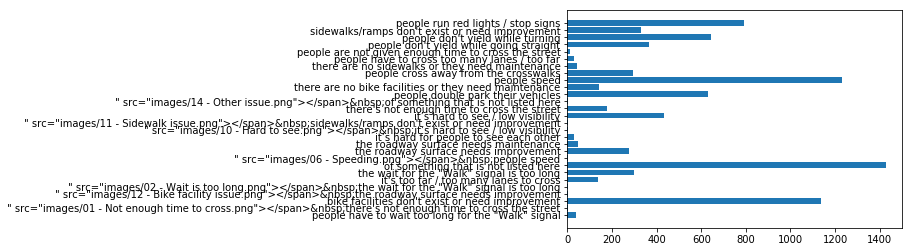

In [172]:
#Visualize the distribution of the categories


print(data['REQUESTTYPE'].unique())
plt.barh(range(len(data['REQUESTTYPE'].unique())), list(Counter(data['REQUESTTYPE']).values()), align='center')
plt.yticks(range(len(data['REQUESTTYPE'].unique())), list(Counter(data['REQUESTTYPE']).keys()))


In [173]:
#Remove rows with no comments
#Remove duplicate rows that have the same category and comment
#Remove rows with comments that are less than 12 characters long
#Create a list of categories
#Consolidate the categories that have embedded images tags into corresponding categories


data = data[data['COMMENTS'].notnull()]
data = data.drop_duplicates(subset=['REQUESTTYPE', 'COMMENTS'])
data = data[data['COMMENTS'].str.len() > 12]


print(len(data['REQUESTTYPE'].unique()))
categories = data['REQUESTTYPE'].unique()
categories = categories.tolist()
categories.sort()

for a in range(len(categories)): print(categories[a])
    
data['REQUESTTYPE'].replace(to_replace=categories[0:7], value=[
        "there's not enough time to cross the street",
    'the wait for the "Walk" signal is too long',
    'people speed', 'it’s hard to see / low visibility',
        "sidewalks/ramps don't exist or need improvement", "the roadway surface needs improvement",
    "of something that is not listed here"], inplace=True)

print(data['REQUESTTYPE'].unique())
print(len(data['REQUESTTYPE'].unique()))


28
" src="images/01 - Not enough time to cross.png"></span>&nbsp;there's not enough time to cross the street
" src="images/02 - Wait is too long.png"></span>&nbsp;the wait for the "Walk" signal is too long
" src="images/06 - Speeding.png"></span>&nbsp;people speed
" src="images/10 - Hard to see.png"></span>&nbsp;it’s hard to see / low visibility
" src="images/11 - Sidewalk issue.png"></span>&nbsp;sidewalks/ramps don't exist or need improvement
" src="images/12 - Bike facility issue.png"></span>&nbsp;the roadway surface needs improvement
" src="images/14 - Other issue.png"></span>&nbsp;of something that is not listed here
bike facilities don't exist or need improvement
it's too far / too many lanes to cross
it’s hard for people to see each other
it’s hard to see / low visibility
of something that is not listed here
people are not given enough time to cross the street
people cross away from the crosswalks
people don't yield while going straight
people don't yield while turning
people dou

["bike facilities don't exist or need improvement" 'of something that is not listed here'
 "people don't yield while going straight" 'it’s hard to see / low visibility'
 "people don't yield while turning" 'the wait for the "Walk" signal is too long'
 "sidewalks/ramps don't exist or need improvement" 'people cross away from the crosswalks'
 'people double park their vehicles' 'people speed' 'people run red lights / stop signs'
 "it's too far / too many lanes to cross" "there's not enough time to cross the street"
 'the roadway surface needs improvement' 'there are no bike facilities or they need maintenance'
 'the roadway surface needs maintenance' 'people have to cross too many lanes / too far'
 'there are no sidewalks or they need maintenance' 'it’s hard for people to see each other'
 'people have to wait too long for the "Walk" signal'
 'people are not given enough time to cross the street']


([<matplotlib.axis.YTick at 0x1e289376898>,
 <a list of 21 Text yticklabel objects>)

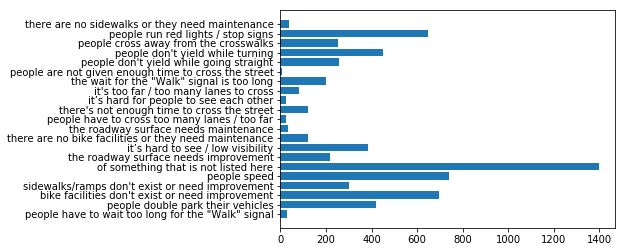

In [174]:
#Visualize the distribution of the categories after the first round of category consolidation


print(data['REQUESTTYPE'].unique())
plt.barh(range(len(data['REQUESTTYPE'].unique())), list(Counter(data['REQUESTTYPE']).values()), align='center')
plt.yticks(range(len(data['REQUESTTYPE'].unique())), list(Counter(data['REQUESTTYPE']).keys()))


In [175]:
#Count how many occurrences of each category occur in the dataset
#Create a list with tuples containing each category and its number of occurrences


count = Counter(data['REQUESTTYPE'])
count = count.items()
count = list(count)
count.sort()
print(count)

print(count[14][0], count[19][0])
print(count[0][0], count[18][0])
print(count[11][0], count[17][0])
print(count[15][0], count[16][0])
print(count[2][0], count[3][0])
print(count[1][0], count[10][0])
print(count[5][0], count[20][0])


[("bike facilities don't exist or need improvement", 695), ("it's too far / too many lanes to cross", 82), ('it’s hard for people to see each other', 26), ('it’s hard to see / low visibility', 385), ('of something that is not listed here', 1400), ('people are not given enough time to cross the street', 9), ('people cross away from the crosswalks', 254), ("people don't yield while going straight", 256), ("people don't yield while turning", 451), ('people double park their vehicles', 418), ('people have to cross too many lanes / too far', 24), ('people have to wait too long for the "Walk" signal', 27), ('people run red lights / stop signs', 647), ('people speed', 741), ("sidewalks/ramps don't exist or need improvement", 299), ('the roadway surface needs improvement', 216), ('the roadway surface needs maintenance', 34), ('the wait for the "Walk" signal is too long', 198), ('there are no bike facilities or they need maintenance', 122), ('there are no sidewalks or they need maintenance', 38

In [176]:
#For each category pair, check which category appears less often
#Replace that category with the other category


#bike facilities don't exist or need improvement / there are no bike facilities or they need maintenance


if count[0][1] > count[18][1]: 
    data['REQUESTTYPE'].replace(to_replace=count[18][0], value=count[0][0], inplace=True)

elif count[18][1] > count[0][1]:
    data['REQUESTTYPE'].replace(to_replace=count[0][0], value=count[18][0], inplace=True)

    
#sidewalks/ramps don't exist or need improvement / there are no sidewalks or they need maintenance


if count[14][1] > count[19][1]:
    data['REQUESTTYPE'].replace(to_replace=count[19][0], value=count[14][0], inplace=True)
    
elif count[19][1] > count[14][1]:
    data['REQUESTTYPE'].replace(to_replace=count[14][0], value=count[19][0], inplace=True)
    
    
#people have to wait too long for the "Walk" signal / the wait for the "Walk" signal is too long


if count[11][1] > count[17][1]:
    data['REQUESTTYPE'].replace(to_replace=count[17][0], value=count[11][0], inplace=True)
    
elif count[17][1] > count[11][1]:
    data['REQUESTTYPE'].replace(to_replace=count[11][0], value=count[17][0], inplace=True)
    

#the roadway surface needs improvement / the roadway surface needs maintenance


if count[15][1] > count[16][1]:
    data['REQUESTTYPE'].replace(to_replace=count[16][0], value=count[15][0], inplace=True)
    
elif count[16][1] > count[15][1]:
    data['REQUESTTYPE'].replace(to_replace=count[15][0], value=count[16][0], inplace=True)
    
    
#it’s hard to see / low visibility / it’s hard for people to see each other


if count[2][1] > count[3][1]:
    data['REQUESTTYPE'].replace(to_replace=count[3][0], value=count[2][0], inplace=True)
    
elif count[3][1] > count[2][1]:
    data['REQUESTTYPE'].replace(to_replace=count[2][0], value=count[3][0], inplace=True)
    
    
#it's too far / too many lanes to cross / people have to cross too many lanes / too far


if count[1][1] > count[10][1]:
    data['REQUESTTYPE'].replace(to_replace=count[10][0], value=count[1][0], inplace=True)
    
elif count[10][1] > count[1][1]:
    data['REQUESTTYPE'].replace(to_replace[1][0], value=count[10][0], inplace=True)

    
#people are not given enough time to cross the street / there's not enough time to cross the street


if count[5][1] > count[20][1]:
    data['REQUESTTYPE'].replace(to_replace=count[20][0], value=count[5][0], inplace=True)
    
elif count[20][1] > count[5][1]:
    data['REQUESTTYPE'].replace(to_replace=count[5][0], value=count[20][0], inplace=True)

print(Counter(data['REQUESTTYPE']))
print(len(data['REQUESTTYPE'].unique()))


Counter({'of something that is not listed here': 1400, "bike facilities don't exist or need improvement": 817, 'people speed': 741, 'people run red lights / stop signs': 647, "people don't yield while turning": 451, 'people double park their vehicles': 418, 'it’s hard to see / low visibility': 411, "sidewalks/ramps don't exist or need improvement": 337, "people don't yield while going straight": 256, 'people cross away from the crosswalks': 254, 'the roadway surface needs improvement': 250, 'the wait for the "Walk" signal is too long': 225, "there's not enough time to cross the street": 131, "it's too far / too many lanes to cross": 106})
14


In [178]:
#Make a copy of the dataset
#Separate the features from the response variable

consolidated_data = data.copy()

target = data['REQUESTTYPE']
comments = data['COMMENTS']


["bike facilities don't exist or need improvement" 'of something that is not listed here'
 "people don't yield while going straight" 'it’s hard to see / low visibility'
 "people don't yield while turning" 'the wait for the "Walk" signal is too long'
 "sidewalks/ramps don't exist or need improvement" 'people cross away from the crosswalks'
 'people double park their vehicles' 'people speed' 'people run red lights / stop signs'
 "it's too far / too many lanes to cross" "there's not enough time to cross the street"
 'the roadway surface needs improvement']


([<matplotlib.axis.YTick at 0x1e283f6d208>,
 <a list of 14 Text yticklabel objects>)

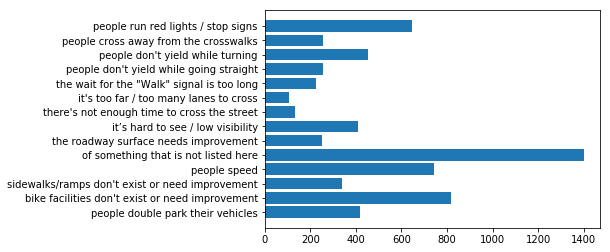

In [179]:
#Visualize the distribution of the consolidated categories


print(target.unique())
plt.barh(range(len(target.unique())), list(Counter(target).values()), align='center')
plt.yticks(range(len(target.unique())), list(Counter(target).keys()))


# Task2 - Model 1 [10 points]

Run a baseline multi-class classification model using a bag-of-word approach, report macro f1-score (should be above .5) and visualize the confusion matrix. Can you interpret the mistakes made by the model? 

The original selection of 28 categories have now been consolidated into the following 14:


1. "bike facilities don't exist or need improvement"

2. "of something that is not listed here"

3. "people don't yield while going straight"

4. "it’s hard to see / low visibility"

5. "people don't yield while turning"

6. "the wait for the "Walk" signal is too long"

7. "sidewalks/ramps don't exist or need improvement"

8. "people cross away from the crosswalks"

9. "people double park their vehicles"

10. "people speed"

11. "people run red lights / stop signs"

12. "it's too far / too many lanes to cross"

13. "there's not enough time to cross the street"

14. "the roadway surface needs improvement"
 
 

In [154]:
#Split the dataset into training and test sets
#Vectorize the comments


comments_train, comments_test, target_train, target_test = train_test_split(comments, target, stratify=target)

X_train = vect.fit_transform(comments_train)
X_test = vect.transform(comments_test)

#X_train_scaled = reg.fit_transform(X_train)
#X_test_scaled = reg.transform(X_test)


In [155]:
#Score a baseline multinomial naive Bayes model using F1-macro score

#lr = LogisticRegressionCV(scoring='f1_macro', n_jobs=8, random_state=3)
#lr.fit(X_train_scaled, target_train)

nb = MultinomialNB()
nb.fit(X_train, target_train)
baseline = f1_score(target_train, nb.predict(X_train), average='macro')

print('Baseline F1 Macro score:', baseline)

assert baseline > 0.5


Baseline F1 Macro score: 0.644892779125


In [156]:
#Display the confusion matrix


np.set_printoptions(linewidth=100)

print(confusion_matrix(target_train, nb.predict(X_train)))
print(classification_report(target_train, nb.predict(X_train)))
      

[[552   0   0  49   1   0   1   1   3   3   0   3   0   0]
 [  7   7   2  43   3   0   2   0   3   6   0   1   5   0]
 [  3   0 208  68   0   1   5   3   9  11   0   0   0   0]
 [ 58   0   6 870   5   2   8  11  33  39  11   2   5   0]
 [  1   0   1  87  84   0   0   1   7   9   1   0   0   0]
 [  2   0   2  73   0  48  19   0  27  20   1   0   0   0]
 [ 12   0   4 104   0   4 189   0  14   9   0   0   2   0]
 [ 17   0   3  37   1   0   0 254   2   0   0   0   0   0]
 [  2   0   3  58   0   1   6   1 399  14   0   0   1   0]
 [ 14   0   8  55   0   1   7   1  22 448   0   0   0   0]
 [ 17   0   4  60   0   0   1   1   0  10 159   0   1   0]
 [ 42   0   1  31   0   0   1   0   1   4   4 102   1   0]
 [  1   0   0  35   0   0   2   0  14   1   0   0 116   0]
 [  1   0   1  41   1   0   6   0  13   6   1   0   4  24]]
                                                 precision    recall  f1-score   support

bike facilities don't exist or need improvement       0.76      0.90      0.82     

From the confusion matrix and classification report, it appears that model is having trouble with these particular aspects of the model:

1. There are a great number of data points that are incorrectly classified as "of something that is not listed here". There are also many data points belonging to that category but incorrectly classified as other categories. Browsing through the comments belonging to "of something that is not listed here", it seems that many should belong to categories that already exist. Without having looked at the interface through which these complaints were collected, I would guess that maybe "of something that is not listed here" is the default option and many people don't bother changing it before submitting their complaints

2. The similarities between comments in the group "people don't yield while going straight", "people don't yield while turning", and "people run red lights / stop signs" are confusing the model. In the confusion matrix, it appears that a portion of the data points in each category are being mistakenly classified as other categories in this group.

3. Some data points in the "people speed" and "people run red lights / stop signs" categories are being mistakenly categorized as the other category. Similar to #1, many other data points belonging to other categories are being mistakenly categorized as one of these two categories.

4. Some data points in the group "bike facilities don't exist or need improvement", "sidewalks/ramps don't exist or need improvement", and "the roadway surface needs improvement" categories are being mistakenly categorized as other categories in this group. This seems to be due to the fact that complaints about bike facilities include those about poor road conditions or faded lane marking paint in bike lanes, which would overlap with comments about sidewalks and roadway conditions.

5. About 18% of the data points in the "there's not enough time to cross the street" category were mistakenly categorized as "it's too far / too many lanes to cross". These two categories should be considered for future consolidation.


# Task3 - Model 2 [30 points]

Improve the model using more complex text features, including n-grams, character n-grams and possibly domain-specific features.

In [157]:
#Remove stop words when vectorizing the dataset


stop = CountVectorizer(stop_words='english')

X_train = stop.fit_transform(comments_train)
X_test = stop.transform(comments_test)

nb.fit(X_train, target_train)
print(f1_score(target_train, nb.predict(X_train), average='macro'))


0.644892779125


Best score achieved through GridSearchCV with a Multinomial Naive Bayes model:
    

0.521056831865


Best parameters:


{'normalizer': None, 'min_df': 3, 'analyzer': 'char', 'ngram_range': (5, 5)}



In [ ]:
#Grid search using a naive Bayes model to find the best model paramaters


params = {'countvectorizer__ngram_range': [(1, 1), (1, 2), (1, 5), (1, 7),
                                (2, 3), (2, 5), (3, 8), (5, 5)],
             'countvectorizer__analyzer': ['word', 'char', 'char_wb'],
           'countvectorizer__min_df': [1, 2, 3],
           'normalizer': [None, Normalizer()]
}

nb_grid = GridSearchCV(make_pipeline(CountVectorizer(stop_words='english'),
                                  Normalizer(), MultinomialNB()) ,
                    param_grid=params, cv=5, scoring='f1_macro', n_jobs=8)

nb_grid.fit(comments_train, target_train)
print(nb_grid.best_score_)
print(nb_grid.best_params_)


This section has been commented out to prevent Travis-CI from timing out
------------------------------------------------------------------------

Best score achieved through GridSearchCV with a logistic regression model:


0.544554548341


Best parameters:


{'normalizer': None, 'ngram_range': (3, 8), 'min_df': 2, 'analyzer': 'char', 'C': 0.1}




In [192]:
#Grid search using a logistic regression model to find the best model paramaters


#lr_params = {'countvectorizer__ngram_range': [(1, 1), (1, 2), (1, 5), (1, 7),
#                                (2, 3), (2, 5), (3, 8), (5, 5)],
#             'countvectorizer__analyzer': ['word', 'char', 'char_wb'],
#           'countvectorizer__min_df': [1, 2, 3],
#           'normalizer': [None, Normalizer()],
#          'logisticregression__C': [100, 10, 1, 0.1, 0.01]
#        }

#lr_grid = GridSearchCV(make_pipeline(CountVectorizer(stop_words='english'),
#                                    Normalizer(), LogisticRegression()), 
#                       param_grid=lr_params, cv=5, scoring='f1_macro', n_jobs=8, verbose=2)

#lr_grid.fit(comments_train, target_train)
#print(lr_grid.best_score_)
#print(lr_grid.best_params_)


Fitting 5 folds for each of 720 candidates, totalling 3600 fits


[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    8.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:  1.2min
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:  4.8min
[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:  5.9min
[Parallel(n_jobs=8)]: Done 997 tasks      | elapsed:  7.2min
[Parallel(n_jobs=8)]: Done 1442 tasks      | elapsed: 26.6min
[Parallel(n_jobs=8)]: Done 1969 tasks      | elapsed: 68.1min
[Parallel(n_jobs=8)]: Done 2576 tasks      | elapsed: 96.8min
[Parallel(n_jobs=8)]: Done 3265 tasks      | elapsed: 123.1min
[Parallel(n_jobs=8)]: Done 3600 out of 3600 | elapsed: 135.9min finished


0.544554548341
{'normalizer': None, 'countvectorizer__ngram_range': (3, 8), 'countvectorizer__min_df': 2, 'countvectorizer__analyzer': 'char', 'logisticregression__C': 0.1}


This section has been commented out to prevent Travis-CI from timing out
------------------------------------------------------------------------

Best score achieved through GridSearchCV with a random forest model:


0.505797024798


Best parameters:


{'normalizer': None, 'n_estimators': 200, 'ngram_range': (5, 5), 'analyzer': 'char', 'min_df': 3}



In [184]:
#Grid search using a random forest model to find the best model parameters


#rf_params = {'countvectorizer__ngram_range': [(1, 1), (1, 2), (1, 5), (1, 7),
#                                (2, 3), (2, 5), (3, 8), (5, 5)],
#             'countvectorizer__analyzer': ['word', 'char', 'char_wb'],
#           'countvectorizer__min_df': [1, 2, 3],
#           'normalizer': [None, Normalizer()],
#             'randomforestclassifier__n_estimators': [50, 100, 150, 200],
#        }

#rf_grid = GridSearchCV(make_pipeline(CountVectorizer(stop_words='english'),
#                                    Normalizer(), RandomForestClassifier()),
#                      param_grid=rf_params, cv=5, scoring='f1_macro', n_jobs=8, verbose=3)

#rf_grid.fit(comments_train, target_train)
#print(rf_grid.best_score_)
#print(rf_grid.best_params_)


Fitting 5 folds for each of 576 candidates, totalling 2880 fits


[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:   27.4s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:  9.6min
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed: 36.1min
[Parallel(n_jobs=8)]: Done 496 tasks      | elapsed: 43.5min
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed: 49.0min
[Parallel(n_jobs=8)]: Done 1136 tasks      | elapsed: 66.6min
[Parallel(n_jobs=8)]: Done 1552 tasks      | elapsed: 107.0min
[Parallel(n_jobs=8)]: Done 2032 tasks      | elapsed: 133.7min
[Parallel(n_jobs=8)]: Done 2576 tasks      | elapsed: 160.3min
[Parallel(n_jobs=8)]: Done 2880 out of 2880 | elapsed: 172.5min finished


0.505797024798
{'normalizer': None, 'randomforestclassifier__n_estimators': 200, 'countvectorizer__ngram_range': (5, 5), 'countvectorizer__analyzer': 'char', 'countvectorizer__min_df': 3}


In [ ]:
#from sklearn.svm import SVC

#sv_params = {'countvectorizer__ngram_range': [(1, 1), (1, 2), (1, 5), (1, 7),
#                                (2, 3), (2, 5), (3, 8), (5, 5)],
#             'countvectorizer__analyzer': ['word', 'char', 'char_wb'],
#           'countvectorizer__min_df': [1, 2, 3],
#           'normalizer': [None, Normalizer()],
#          'svc__C': [100, 10, 1, 0.1, 0.01]
#        }

#sv_grid = GridSearchCV(make_pipeline(CountVectorizer(stop_words='english'),
#                                     Normalizer(), SVC()),
#                                    param_grid=sv_params, cv=5, scoring='f1_macro', verbose=2)

#sv_grid.fit(comments_train, target_train)
#print(sv_grid.best_score_)
#print(sv_grid.best_params_)


# Task4 - Visualize Results [10 points]

Visualize results of the tuned model (classification results, confusion matrix, important features, example mistakes).

In [4]:
# Add your code for task 4 here. You may use multiple cells. 



# Task5 - Clustering [10 points]

Apply LDA, NMF and K-Means to the whole dataset. Can you find clusters or topics that match well with some of the ground truth labels? Use ARI to compare the methods and visualize topics and clusters.

In [5]:
# Add your code for task 5 here. You may use multiple cells. 



# Task6 - Model 3 [30 points]

Improve the class definition for REQUESTTYPE by using the results of the clustering and results of the previous classification model. Re-assign labels using either the results of clustering or using keywords that you found during data exploration. The labels must be semantically meaningful.
The data has a large “other” category. Apply the topic modeling and clustering techniques to this subset of the data to find possible splits of this class.
Report accuracy using macro average f1 score (should be above .53) 


In [6]:
# Add your code for task 6 here. You may use multiple cells. 



# Extra Credit [Up to +20 points]

Use a word embedding representation like word2vec for step 3 and or step 6. 

In [7]:
# Add your code for extra credit here. You may use multiple cells. 

